# Importing Libraries

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense
from keras.layers import LSTM,Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [102]:
# Read the data
data=pd.read_csv("generated_data.csv")

In [103]:
data

,timestamp,temperature,pressure,humidity,temperature_status,pressure_status,humidity_status
0,2023-01-01 00:00:00,28.10,105.27,32.26,normal,normal,anomalous
1,2023-01-01 00:05:00,22.53,102.69,71.83,anomalous,normal,anomalous
2,2023-01-01 00:10:00,34.63,100.23,65.88,normal,normal,normal
3,2023-01-01 00:15:00,25.32,81.32,74.68,normal,anomalous,anomalous
4,2023-01-01 00:20:00,28.75,97.69,42.93,normal,normal,normal
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,39.72,109.03,57.36,anomalous,normal,normal
996,2023-01-04 11:00:00,38.78,103.67,77.07,anomalous,normal,anomalous
997,2023-01-04 11:05:00,35.97,111.50,72.28,anomalous,anomalous,anomalous
998,2023-01-04 11:10:00,24.67,95.94,68.69,anomalous,normal,normal


# Pressure sensor

#### Convert the pressure status from catorigical to numerical

In [104]:
# Select the timestamp,pressure column and the pressure_status column from the data
data_pressure = data.loc[:, ['timestamp', 'pressure',"pressure_status"]]
data_pressure

,timestamp,pressure,pressure_status
0,2023-01-01 00:00:00,105.27,normal
1,2023-01-01 00:05:00,102.69,normal
2,2023-01-01 00:10:00,100.23,normal
3,2023-01-01 00:15:00,81.32,anomalous
4,2023-01-01 00:20:00,97.69,normal
...,...,...,...
995,2023-01-04 10:55:00,109.03,normal
996,2023-01-04 11:00:00,103.67,normal
997,2023-01-04 11:05:00,111.50,anomalous
998,2023-01-04 11:10:00,95.94,normal


In [105]:
# Convert the pressure_status column to binary values
data_pressure.loc[data_pressure["pressure_status"]=="normal","pressure_status"]=0
data_pressure.loc[data_pressure["pressure_status"]=="anomalous","pressure_status"]=1
data_pressure

,timestamp,pressure,pressure_status
0,2023-01-01 00:00:00,105.27,0
1,2023-01-01 00:05:00,102.69,0
2,2023-01-01 00:10:00,100.23,0
3,2023-01-01 00:15:00,81.32,1
4,2023-01-01 00:20:00,97.69,0
...,...,...,...
995,2023-01-04 10:55:00,109.03,0
996,2023-01-04 11:00:00,103.67,0
997,2023-01-04 11:05:00,111.50,1
998,2023-01-04 11:10:00,95.94,0


In [106]:
def standraization(df, column_name):
    # Calculate Z-scores
    z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
    df["pressure_standar"]=z_scores
    return df

In [107]:
data_pressure["pressure"].min(), data_pressure["pressure"].max()

(80.12, 119.98)

##### Analysing the data readout and plot a sample

In [108]:
# The number of normal and anomalous pressure values
data_pressure.loc[data_pressure["pressure_status"]==0]["timestamp"].count(), data_pressure.loc[data_pressure["pressure_status"]==1]["timestamp"].count()

(533, 467)

In [109]:
# The range of timestamps
data_pressure["timestamp"].min(), data_pressure["timestamp"].max()

('2023-01-01 00:00:00', '2023-01-04 11:15:00')

In [110]:
# The number of pressure values recorded on the first two days
first_2days= data_pressure.loc[data_pressure["timestamp"]<'2023-01-03']
first_2days

,timestamp,pressure,pressure_status
0,2023-01-01 00:00:00,105.27,0
1,2023-01-01 00:05:00,102.69,0
2,2023-01-01 00:10:00,100.23,0
3,2023-01-01 00:15:00,81.32,1
4,2023-01-01 00:20:00,97.69,0
...,...,...,...
571,2023-01-02 23:35:00,105.12,0
572,2023-01-02 23:40:00,105.36,0
573,2023-01-02 23:45:00,101.92,0
574,2023-01-02 23:50:00,106.50,0


In [111]:
# The number of normal and anomalous pressure values recorded on the first two days
first_2days.loc[first_2days["pressure_status"]==0]["timestamp"].count(), first_2days.loc[first_2days["pressure_status"]==1]["timestamp"].count()

(306, 270)

In [112]:
therd_day= data_pressure.loc[(data_pressure["timestamp"]>'2023-01-03') & (data_pressure["timestamp"]<'2023-01-04')]

In [113]:
therd_day

,timestamp,pressure,pressure_status
576,2023-01-03 00:00:00,94.85,0
577,2023-01-03 00:05:00,95.43,0
578,2023-01-03 00:10:00,116.52,1
579,2023-01-03 00:15:00,99.73,0
580,2023-01-03 00:20:00,95.79,0
...,...,...,...
859,2023-01-03 23:35:00,108.97,0
860,2023-01-03 23:40:00,83.90,1
861,2023-01-03 23:45:00,83.99,1
862,2023-01-03 23:50:00,97.30,0


In [114]:
# The number of normal and anomalous pressure values recorded on the therd day
therd_day.loc[therd_day["pressure_status"]==0]["timestamp"].count(), therd_day.loc[therd_day["pressure_status"]==1]["timestamp"].count()

(152, 136)

In [115]:
# The number of pressure values recorded on the last day
last_day= data_pressure.loc[data_pressure["timestamp"]>='2023-01-04']
last_day

,timestamp,pressure,pressure_status
864,2023-01-04 00:00:00,89.37,1
865,2023-01-04 00:05:00,114.14,1
866,2023-01-04 00:10:00,106.40,0
867,2023-01-04 00:15:00,91.31,0
868,2023-01-04 00:20:00,87.68,1
...,...,...,...
995,2023-01-04 10:55:00,109.03,0
996,2023-01-04 11:00:00,103.67,0
997,2023-01-04 11:05:00,111.50,1
998,2023-01-04 11:10:00,95.94,0


In [116]:
# The number of normal and anomalous pressure values recorded on the last two days
last_day.loc[last_day["pressure_status"]==0]["timestamp"].count(), last_day.loc[last_day["pressure_status"]==1]["timestamp"].count()

(75, 61)

In [117]:
# Standarize the pressure values
first_2days=standraization(first_2days, "pressure")
therd_day=standraization(therd_day, "pressure")
last_day=standraization(last_day, "pressure")

C:\Users\adnan\AppData\Local\Temp\ipykernel_7616\3060150468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pressure_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_7616\3060150468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pressure_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_7616\3060150468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [118]:
# first 7 rows
data_pressure.head(7)

,timestamp,pressure,pressure_status
0,2023-01-01 00:00:00,105.27,0
1,2023-01-01 00:05:00,102.69,0
2,2023-01-01 00:10:00,100.23,0
3,2023-01-01 00:15:00,81.32,1
4,2023-01-01 00:20:00,97.69,0
5,2023-01-01 00:25:00,108.99,0
6,2023-01-01 00:30:00,86.49,1


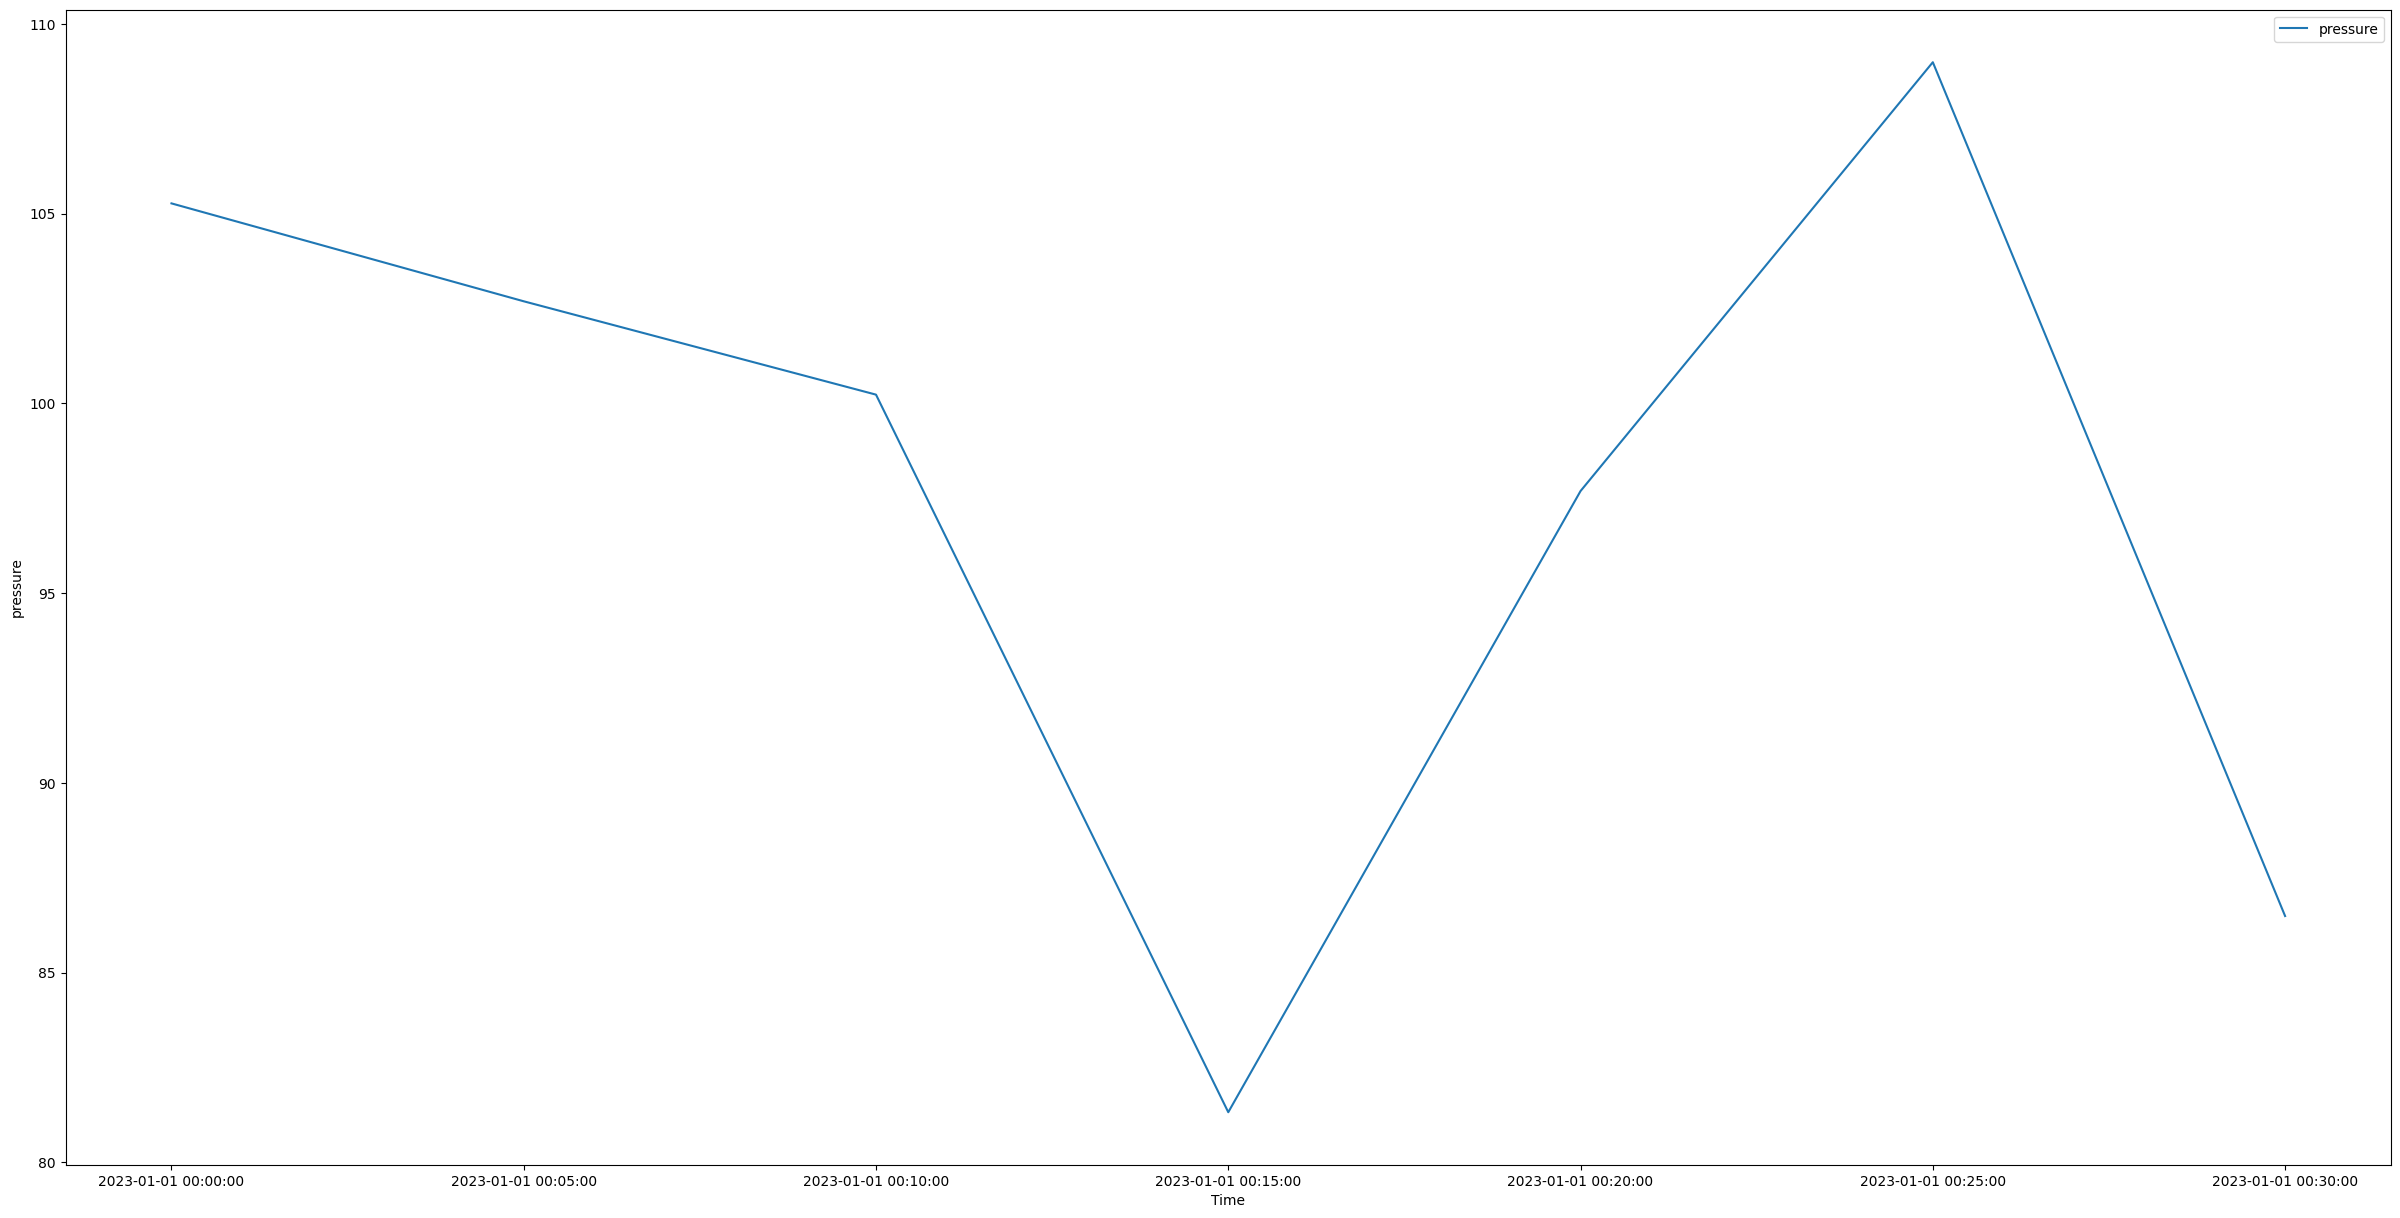

In [119]:
# Plot the first 7 pressure values
plt.figure(figsize=(30,15))
plt.plot(data_pressure["timestamp"].head(7), data_pressure["pressure"].head(7), label="pressure")
plt.xlabel("Time")
plt.ylabel("pressure")
plt.legend()
plt.show()

- The data is balanced there are almost same number of reads out for each class.
- We can see the stand pressure can indicate a strong variasion between the previos pressure and the current one whcih help the model to idenife if there are some anomalous values.
- Window size of 1 readout which indicate a 5 minute.
- Split the data into test and train, the data are collected in 4 days, so train 2 days,valdation 1 day and test 1 day.

##### Spliting the data

In [120]:
train = first_2days
valdation= therd_day
test = last_day

In [121]:
train

,timestamp,pressure,pressure_status,pressure_standar
0,2023-01-01 00:00:00,105.27,0,0.498629
1,2023-01-01 00:05:00,102.69,0,0.270903
2,2023-01-01 00:10:00,100.23,0,0.053769
3,2023-01-01 00:15:00,81.32,1,1.615341
4,2023-01-01 00:20:00,97.69,0,0.170427
...,...,...,...,...
571,2023-01-02 23:35:00,105.12,0,0.485389
572,2023-01-02 23:40:00,105.36,0,0.506573
573,2023-01-02 23:45:00,101.92,0,0.202938
574,2023-01-02 23:50:00,106.50,0,0.607197


##### Preparing the data in sequences (number of samples, window size, number of features)

In [122]:
def sequence(data, timesteps, num_features):
    num_samples = len(data) - timesteps + 1  
    df = np.zeros((num_samples, timesteps, num_features))
    for i in range(num_samples):
        df[i] = data[i:i+timesteps, :] 

    return df

In [123]:
def prepare_y(train, timesteps):
    num_samples = len(train) - timesteps + 1
    y_train = np.zeros((num_samples, 1))
    for i in range(num_samples):
        y_train[i] = train["pressure_status"].values[i + timesteps - 1]

    return y_train

In [124]:
data_n= train.loc[train["pressure_status"]==0]
data_d = data_n.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_train = sequence(data_d, 1, 1)
x_train.shape

(306, 1, 1)

In [125]:
data_n= valdation.loc[valdation["pressure_status"]==0]
data_d = data_n.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_valdation = sequence(data_d, 1, 1)
x_valdation.shape

(152, 1, 1)

In [126]:
data_t = test.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_test = sequence(data_t, 1, 1)
x_test.shape

(136, 1, 1)

#### Autoencoder LSTM model

In [127]:

timesteps = x_train.shape[1]
n_features = x_train.shape[2]

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(Input(shape=(timesteps, n_features)))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 1, 16)          │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 1, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 1, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 1, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,977 (20.02 MB)

 Trainable params: 5,248,977 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [129]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(x_train,x_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation, x_valdation),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400


10/10 - 7s - 747ms/step - loss: 0.2730 - val_loss: 0.2575
Epoch 2/400
10/10 - 0s - 17ms/step - loss: 0.2720 - val_loss: 0.2565
Epoch 3/400
10/10 - 0s - 16ms/step - loss: 0.2709 - val_loss: 0.2554
Epoch 4/400
10/10 - 0s - 17ms/step - loss: 0.2698 - val_loss: 0.2544
Epoch 5/400
10/10 - 0s - 18ms/step - loss: 0.2687 - val_loss: 0.2533
Epoch 6/400
10/10 - 0s - 17ms/step - loss: 0.2677 - val_loss: 0.2523
Epoch 7/400
10/10 - 0s - 17ms/step - loss: 0.2666 - val_loss: 0.2513
Epoch 8/400
10/10 - 0s - 18ms/step - loss: 0.2655 - val_loss: 0.2502
Epoch 9/400
10/10 - 0s - 18ms/step - loss: 0.2644 - val_loss: 0.2492
Epoch 10/400
10/10 - 0s - 16ms/step - loss: 0.2634 - val_loss: 0.2482
Epoch 11/400
10/10 - 0s - 16ms/step - loss: 0.2623 - val_loss: 0.2471
Epoch 12/400
10/10 - 0s - 16ms/step - loss: 0.2612 - val_loss: 0.2461
Epoch 13/400
10/10 - 0s - 18ms/step - loss: 0.2601 - val_loss: 0.2450
Epoch 14/400
10/10 - 0s - 17ms/step - loss: 0.2590 - val_loss: 0.2439
Epoch 15/400
10/10 - 0s - 16ms/step - lo

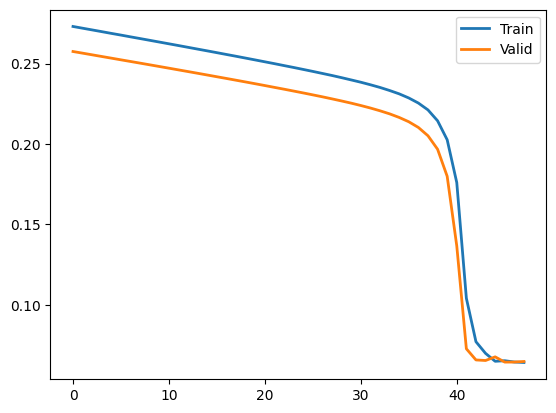

In [130]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Reconstruction error threshold: 0.4701170974099722


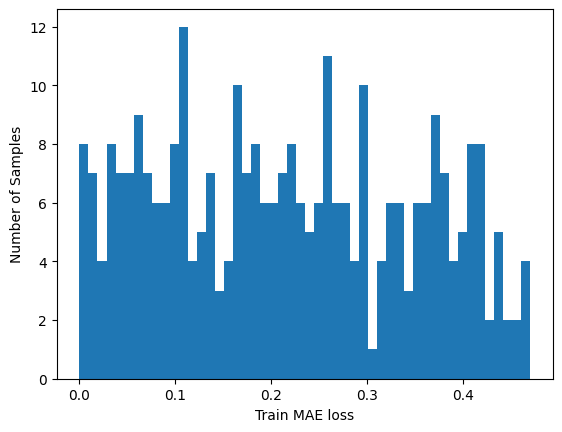

In [131]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0, 0.5, 'Number of samples')

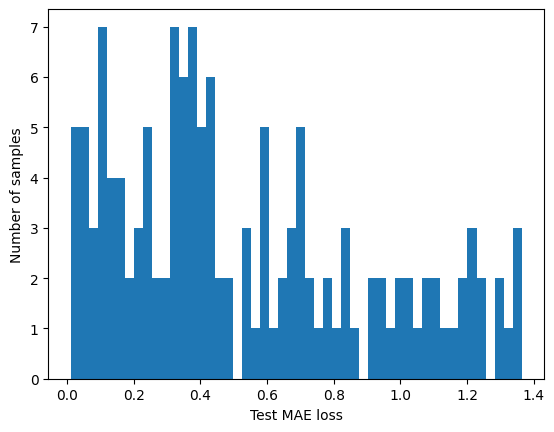

In [132]:
X_test_pred = lstm_autoencoder.predict(x_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [133]:
anomaly_df = test.copy()
anomaly_df.loc[:, 'loss'] = test_mae_loss
anomaly_df.loc[:, 'threshold'] = threshold
anomaly_df.loc[:, 'anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']
anomaly_df

,timestamp,pressure,pressure_status,pressure_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,89.37,1,0.992871,0.553917,0.470117,True
865,2023-01-04 00:05:00,114.14,1,1.269480,0.830511,0.470117,True
866,2023-01-04 00:10:00,106.40,0,0.562552,0.123624,0.470117,False
867,2023-01-04 00:15:00,91.31,0,0.815683,0.376739,0.470117,False
868,2023-01-04 00:20:00,87.68,1,1.147226,0.708264,0.470117,True
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,109.03,0,0.802761,0.363818,0.470117,False
996,2023-01-04 11:00:00,103.67,0,0.313210,0.125702,0.470117,False
997,2023-01-04 11:05:00,111.50,1,1.028357,0.589401,0.470117,True
998,2023-01-04 11:10:00,95.94,0,0.392805,0.046112,0.470117,False


In [134]:
anomaly_df.loc[anomaly_df['anomaly']==False]=0
anomaly_df.loc[anomaly_df['anomaly']==True]=1
anomaly_df

C:\Users\adnan\AppData\Local\Temp\ipykernel_7616\1612888637.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  anomaly_df.loc[anomaly_df['anomaly']==False]=0


,timestamp,pressure,pressure_status,pressure_standar,loss,threshold,anomaly
864,1,1.0,1,1.0,1.0,1.0,1
865,1,1.0,1,1.0,1.0,1.0,1
866,0,0.0,0,0.0,0.0,0.0,0
867,0,0.0,0,0.0,0.0,0.0,0
868,1,1.0,1,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...
995,0,0.0,0,0.0,0.0,0.0,0
996,0,0.0,0,0.0,0.0,0.0,0
997,1,1.0,1,1.0,1.0,1.0,1
998,0,0.0,0,0.0,0.0,0.0,0


In [135]:
anomaly_df_temp_status=anomaly_df["pressure_status"].astype(int)
anomaly_df_predicted=anomaly_df["anomaly"].astype(int)

In [136]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        61

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136

[[75  0]
 [ 0 61]]


# ______________________________________________________________________________

In [137]:
data_d = train.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_train_both = sequence(data_d, 1, 1)
x_train_both.shape

(576, 1, 1)

In [138]:
data_d = valdation.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_valdation_both = sequence(data_d, 1, 1)
x_valdation_both.shape

(288, 1, 1)

In [139]:
data_t = test.drop(['pressure',"pressure_status","timestamp"], axis=1).values
x_test_both = sequence(data_t, 1, 1)
x_test_both.shape

(136, 1, 1)

In [140]:
timesteps = x_train_both.shape[1]
n_features = x_train_both.shape[2]

lstm_autoencoder_both = Sequential()
# Encoder
lstm_autoencoder_both.add(Input(shape=(timesteps, n_features)))

lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder_both.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=True))

lstm_autoencoder_both.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder_both.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 1)           │           513 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,152,385 (12.03 MB)

 Trainable params: 3,152,385 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [142]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder_both.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history_both = lstm_autoencoder_both.fit(x_train_both,x_train_both, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation_both, x_valdation_both),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400
18/18 - 1s - 69ms/step - loss: 0.4057 - val_loss: 0.2949
Epoch 2/400
18/18 - 0s - 9ms/step - loss: 0.2624 - val_loss: 0.2613
Epoch 3/400
18/18 - 0s - 10ms/step - loss: 0.2563 - val_loss: 0.2575
Epoch 4/400
18/18 - 0s - 9ms/step - loss: 0.2548 - val_loss: 0.2563
Epoch 5/400
18/18 - 0s - 9ms/step - loss: 0.2532 - val_loss: 0.2562
Epoch 6/400
18/18 - 0s - 8ms/step - loss: 0.2530 - val_loss: 0.2549
Epoch 7/400
18/18 - 0s - 8ms/step - loss: 0.2517 - val_loss: 0.2542
Epoch 8/400
18/18 - 0s - 9ms/step - loss: 0.2542 - val_loss: 0.2573
Epoch 9/400
18/18 - 0s - 8ms/step - loss: 0.2500 - val_loss: 0.2535
Epoch 10/400
18/18 - 0s - 9ms/step - loss: 0.2533 - val_loss: 0.2535
Epoch 11/400
18/18 - 0s - 9ms/step - loss: 0.2539 - val_loss: 0.2605
Epoch 12/400
18/18 - 0s - 9ms/step - loss: 0.2543 - val_loss: 0.2515
Epoch 13/400
18/18 - 0s - 9ms/step - loss: 0.2481 - val_loss: 0.2501
Epoch 14/400
18/18 - 0s - 9ms/step - loss: 0.2464 - val_loss: 0.2496
Epoch 15/400
18/18 - 0s - 9ms/step - loss

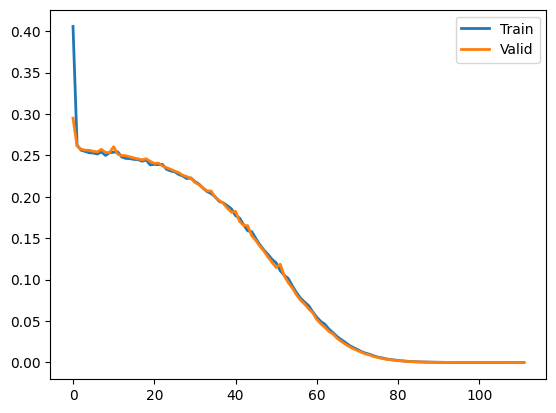

In [143]:
plt.plot(lstm_autoencoder_history_both['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history_both['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Text(0, 0.5, 'Number of Samples')

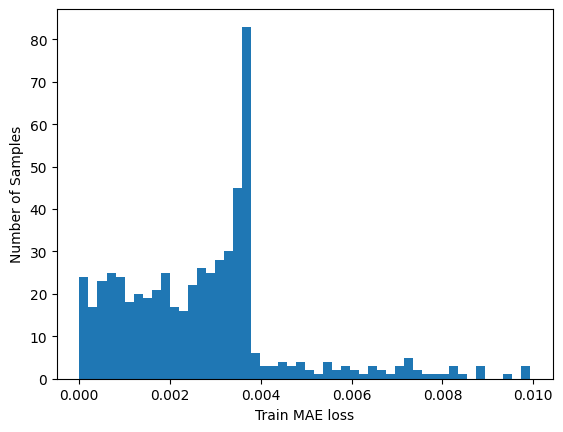

In [144]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder_both.predict(x_train_both)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_both), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

In [157]:
threshold = 0.004

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Number of samples')

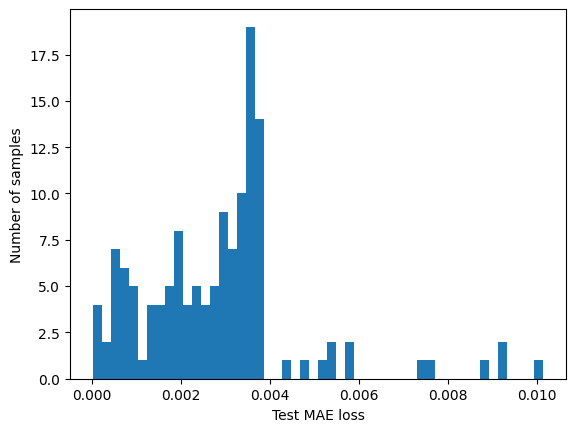

In [158]:
X_test_pred = lstm_autoencoder_both.predict(x_test_both, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test_both), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [159]:
anomaly_df_both = test.copy()
anomaly_df_both.loc[:, 'loss'] = test_mae_loss
anomaly_df_both.loc[:, 'threshold'] = threshold
anomaly_df_both.loc[:, 'anomaly'] = anomaly_df_both['loss'] > anomaly_df_both['threshold']
anomaly_df_both

,timestamp,pressure,pressure_status,pressure_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,89.37,1,0.992871,0.003678,0.004,False
865,2023-01-04 00:05:00,114.14,1,1.269480,0.001965,0.004,False
866,2023-01-04 00:10:00,106.40,0,0.562552,0.002101,0.004,False
867,2023-01-04 00:15:00,91.31,0,0.815683,0.003545,0.004,False
868,2023-01-04 00:20:00,87.68,1,1.147226,0.003044,0.004,False
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,109.03,0,0.802761,0.003504,0.004,False
996,2023-01-04 11:00:00,103.67,0,0.313210,0.000295,0.004,False
997,2023-01-04 11:05:00,111.50,1,1.028357,0.003599,0.004,False
998,2023-01-04 11:10:00,95.94,0,0.392805,0.000543,0.004,False


In [160]:
anomaly_df_both.loc[anomaly_df_both['anomaly']==True].count()

timestamp           13
pressure            13
pressure_status     13
pressure_standar    13
loss                13
threshold           13
anomaly             13
dtype: int64

In [161]:
anomaly_df_temp_status=anomaly_df_both["pressure_status"].astype(int)
anomaly_df_predicted=anomaly_df_both["anomaly"].astype(int)

In [162]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        75
           1       1.00      0.21      0.35        61

    accuracy                           0.65       136
   macro avg       0.80      0.61      0.55       136
weighted avg       0.78      0.65      0.58       136

[[75  0]
 [48 13]]
